In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/agrigorev/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

from sklearn.decomposition import NMF

In [5]:
root = '/home/agrigorev/tmp/telstra/'

event_type = pd.read_csv(root + 'event_type.csv')
log_feature = pd.read_csv(root + 'log_feature.csv')
resource_type = pd.read_csv(root + 'resource_type.csv')
severity_type = pd.read_csv(root + 'severity_type.csv')

In [6]:
train = pd.read_csv(root + 'train.csv')
train.fault_severity = train.fault_severity.astype(np.int)

test = pd.read_csv(root + 'test.csv')

train['source'] = 'TRAIN'
test['source'] = 'TEST'

all_data = pd.concat((train, test), axis=0, ignore_index=1)

In [7]:
severity_type['severity_no'] = severity_type.severity_type.str.strip('severity_type ').astype(int)

In [8]:
def within_group_order(group):
    group_len = len(group)
    order_asc = 1 + np.arange(group_len)
    order_norm = 1.0 * order_asc / group_len
    order_norm_desc = 1 - order_norm
    group['order_asc'] = order_asc
    group['order_norm_asc'] = order_norm
    group['order_norm_desc'] = order_norm_desc
    return group

severity_features = severity_type.merge(all_data, on='id')
severity_features = severity_features.groupby('location').apply(within_group_order) 

severity_features['location_no'] = severity_features.location.str.strip('location ').astype(int)

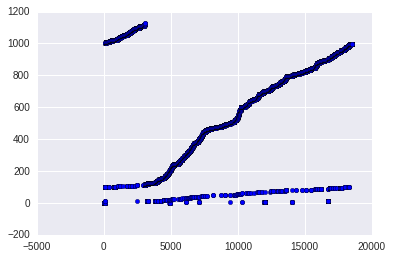

In [9]:
plt.scatter(np.arange(len(severity_features)), severity_features.location_no)
plt.show()

Reproduce figure from https://www.kaggle.com/c/telstra-recruiting-network/forums/t/19239/it-s-been-fun-post-your-code-github-links-here-after-the-competition/109923#post109923

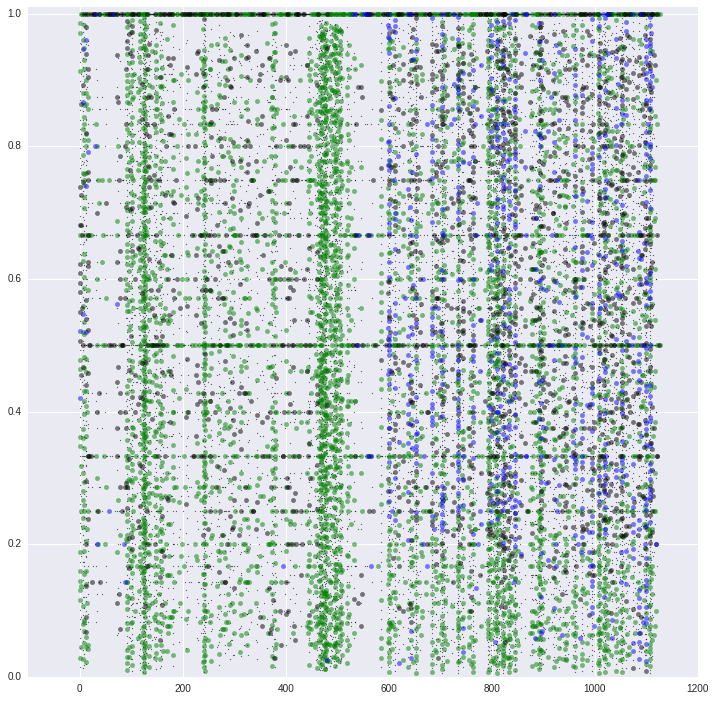

In [10]:
plt.figure(figsize=(12, 12))

plt.scatter(severity_features.loc[severity_features.fault_severity.isnull(), 'location_no'], 
            severity_features.loc[severity_features.fault_severity.isnull(), 'order_norm_asc'],
            alpha=0.5, color='k', s=1)

plt.scatter(severity_features.loc[severity_features.fault_severity == 0, 'location_no'], 
            severity_features.loc[severity_features.fault_severity == 0, 'order_norm_asc'],
            alpha=0.5, color='green')

plt.scatter(severity_features.loc[severity_features.fault_severity == 1, 'location_no'], 
            severity_features.loc[severity_features.fault_severity == 1, 'order_norm_asc'],
            alpha=0.5, color='black')

plt.scatter(severity_features.loc[severity_features.fault_severity == 2, 'location_no'], 
            severity_features.loc[severity_features.fault_severity == 2, 'order_norm_asc'],
            alpha=0.5, color='blue')

plt.xlim(-100, 1200)
plt.ylim(0, 1.01)

plt.show()

In [11]:
severity_features = severity_features[['severity_no', 'order_asc', 'order_norm_asc', 
                                       'order_norm_desc', 'location_no', 'id']]

In [12]:
event_features = []
for i, group in event_type.groupby('id'):
    event_features.append((i, list(group.event_type)))

event_features = pd.DataFrame(event_features)
event_features.columns = ['id', 'event_types']

In [13]:
log_features_sparse = []
for i, group in log_feature.groupby('id'):
    d = dict(zip(group.log_feature, group.volume))
    log_features_sparse.append((i, d))

log_features_sparse = pd.DataFrame(log_features_sparse)
log_features_sparse.columns = ['id', 'log_features']
log_features_sparse['logs_total_volume'] = log_features_sparse.log_features.apply(lambda d: sum(d.values()))

logs_no = log_features_sparse.log_features.apply(len)
log_features_sparse['logs_avg_vol'] = log_features_sparse.logs_total_volume / logs_no

In [14]:
def log_type_to_arr(log_feature):
    return [int(s.strip('feature ')) for s in log_feature.keys()]

log_int = log_features_sparse.log_features.apply(log_type_to_arr)

log_features_sparse['log_ints'] = log_int
log_features_sparse['log_min'] = log_int.apply(np.min)
log_features_sparse['log_max'] = log_int.apply(np.max)
log_features_sparse['log_median'] = log_int.apply(np.median)

In [15]:
resource_features = []
for i, group in resource_type.groupby('id'):
    resource_features.append((i, list(group.resource_type)))

resource_features = pd.DataFrame(resource_features)
resource_features.columns = ['id', 'resource_types']

In [16]:
def resource_type_to_arr(lst):
    return [int(s.strip('resource_type ')) for s in lst]

resource_ints = resource_features.resource_types.apply(resource_type_to_arr)

resource_features['resource_ints'] = resource_ints
resource_features['resource_max'] = resource_ints.apply(np.max)
resource_features['resource_median'] = resource_ints.apply(np.median)

Merging all into one

In [17]:
merged = all_data
merged = merged.merge(event_features, on='id')
merged = merged.merge(log_features_sparse, on='id')
merged = merged.merge(resource_features, on='id')
merged = merged.merge(severity_features, on='id')

Simple model

In [18]:
df_train = merged[merged.source == 'TRAIN']
df_test = merged[merged.source == 'TEST']

In [19]:
numeric_features = set(df_train._get_numeric_data().columns) - {u'fault_severity', u'id'}
numeric_features = sorted(numeric_features)

In [20]:
X = df_train[numeric_features].values
y = df_train.fault_severity.values

In [21]:
parameters = {
    'objective': 'multi:softprob', 'num_class': 3, 'silent': 0, 
    'min_child_weight': 3, 'eta': 0.05, 'colsample_bytree': 0.75,
    'max_depth': 5, 'subsample': 0.9, 'lambda': 0.5, 'nthread': 4,
}

num_rounds = 1000

In [22]:
dtrain = xgb.DMatrix(X, label=y, feature_names=numeric_features)
cv = xgb.cv(parameters, dtrain, nfold=5, metrics='mlogloss', early_stopping_rounds=25, 
            num_boost_round=num_rounds)
cv.tail()

Will train until cv error hasn't decreased in 25 rounds.
Stopping. Best iteration:
[380] cv-mean:0.4687596	cv-std:0.00904842369919


,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
376,0.468836,0.009206,0.281538,0.004627
377,0.468890,0.009159,0.281220,0.004655
378,0.468894,0.009139,0.280913,0.004649
379,0.468854,0.009158,0.280499,0.004628
380,0.468760,0.009048,0.280204,0.004563


In [25]:
model = xgb.train(parameters, dtrain, num_rounds)


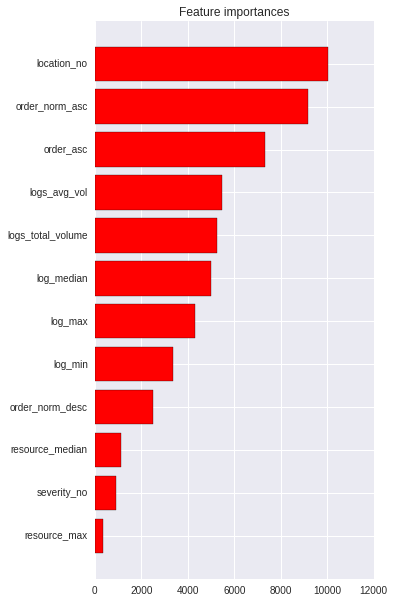

In [26]:
importance = model.get_fscore().items()
importance = sorted(importance, key=lambda k: k[1])
names, importance = zip(*importance)

plt.figure(figsize=(5, 10))
plt.title("Feature importances")

n = len(importance)
plt.barh(range(n), importance, color="r", align="center")

plt.yticks(range(n), names)
plt.ylim([-1, n])

plt.show()

## Submission

In [28]:
dtest = xgb.DMatrix(df_test[numeric_features].values, feature_names=numeric_features)
pred = model.predict(dtest)

In [29]:
submission = pd.DataFrame({
    'id': df_test.id, 
    'predict_0': pred[:, 0],
    'predict_1': pred[:, 1],
    'predict_2': pred[:, 2] 
})
submission.to_csv('submission_post.csv', index=False)

## Improvement

In [30]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

class ItemsSelector(BaseEstimator, TransformerMixin):
    def __init__(self, keys):
        self.keys = keys

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.keys]

    def get_feature_names(self):
        return self.keys

In [31]:
def item_analyzer(x): return [x]
def identity_analyzer(x): return x

In [37]:
union = FeatureUnion(transformer_list=[
    ('numeric', ItemsSelector(numeric_features)),
    ('log_features', Pipeline([
        ('selector', ItemSelector(key='log_features')),
        ('vect', DictVectorizer()),
        ('fs', SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False))),
    ])),
    ('resource_types', Pipeline([
        ('selector', ItemSelector(key='resource_types')),
        ('vect', TfidfVectorizer(analyzer=identity_analyzer)),
    ])),
    ('location_nmf', Pipeline([
        ('selector', ItemSelector(key='location')),
        ('vect', TfidfVectorizer(analyzer=item_analyzer)),
        ('nmf', NMF(n_components=20)),
    ])),
    ('event_types_nmf', Pipeline([
        ('selector', ItemSelector(key='event_types')),
        ('vect', TfidfVectorizer(analyzer=identity_analyzer)),
        ('nmf', NMF(n_components=5)),
    ])),
    ('log_features_nmf', Pipeline([
        ('selector', ItemSelector(key='log_features')),
        ('vect', DictVectorizer()),
        ('nmf', NMF(n_components=15)),
    ])),
    ('resource_type_nmf', Pipeline([
        ('selector', ItemSelector(key='resource_types')),
        ('vect', TfidfVectorizer(analyzer=identity_analyzer)),
        ('nmf', NMF(n_components=3)),
    ])),
])

In [38]:
cnt = 0
for name, transformer in union.transformer_list:
    feature = transformer.fit_transform(df_train, y)
    num_features = feature.shape[1]
    print 'feature:', name.ljust(17), 'dim:', num_features
    cnt = cnt + num_features

print
print 'total:', cnt

feature: numeric           dim: 12
feature: log_features      dim: 55
feature: resource_types    dim: 10
feature: location_nmf      dim: 20
feature: event_types_nmf   dim: 5
feature: log_features_nmf  dim: 15
feature: resource_type_nmf dim: 3

total: 120


In [39]:
feature_names = []

for name, transformer in union.transformer_list:
    if hasattr(transformer, 'get_feature_names'):
        features = transformer.get_feature_names()
        feature_names.extend(features)
        continue
    
    if not isinstance(transformer, Pipeline):
        continue
    
    u_pipe = transformer.named_steps
    
    if 'nmf' in u_pipe:
        nmf = u_pipe['nmf']
        n_comp = nmf.n_components
        nmf_names = ['%s_nmf_%d' %  (name, i) for i in range(n_comp)]
        feature_names.extend(nmf_names)
        continue

    if 'vect' in u_pipe:
        tfidf_names = u_pipe['vect'].get_feature_names()
    if 'fs' in u_pipe:
        tfidf_names = np.array(tfidf_names)
        fs = u_pipe['fs']
        tfidf_names = tfidf_names[fs._get_support_mask()]
    feature_names.extend(tfidf_names)

feature_names = np.array(feature_names)
len(feature_names)

120

In [40]:
X_train = union.fit_transform(df_train, y)
X_test = union.transform(df_test)

In [41]:
parameters = {
    'objective': 'multi:softprob', 'num_class': 3, 'silent': 0, 
    'min_child_weight': 3, 'eta': 0.05, 'colsample_bytree': 0.75,
    'max_depth': 7, 'subsample': 0.9, 'lambda': 0.5, 'nthread': 4,
}

num_rounds = 1000

In [42]:
dtrain = xgb.DMatrix(X_train, label=y, feature_names=feature_names)

In [43]:
cv = xgb.cv(parameters, dtrain, nfold=5, metrics='mlogloss', early_stopping_rounds=250, 
            num_boost_round=num_rounds)
cv.tail()

Will train until cv error hasn't decreased in 250 rounds.
Stopping. Best iteration:
[287] cv-mean:0.4352708	cv-std:0.0082024958982


,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
283,0.435378,0.008282,0.214588,0.003343
284,0.435408,0.008322,0.214169,0.003369
285,0.435407,0.008257,0.213763,0.003283
286,0.435295,0.008244,0.213221,0.003357
287,0.435271,0.008202,0.212734,0.003352


In [45]:
model = xgb.train(parameters, dtrain, num_rounds)

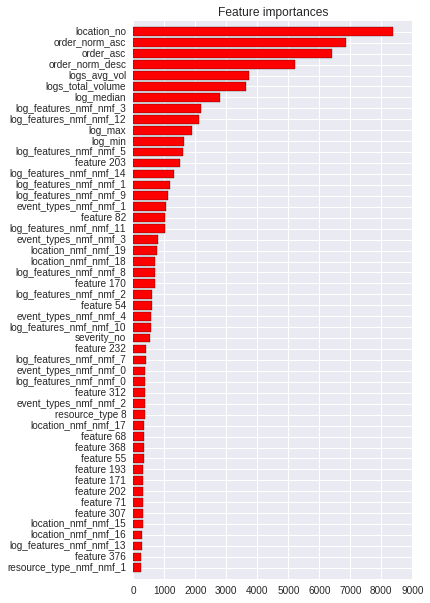

In [46]:
importance = model.get_fscore().items()
importance = sorted(importance, key=lambda k: -k[1])[:50][::-1]
names, importance = zip(*importance)

plt.figure(figsize=(5, 10))
plt.title("Feature importances")

n = len(importance)
plt.barh(range(n), importance, color="r", align="center")

plt.yticks(range(n), names)
plt.ylim([-1, n])

plt.show()

### Submission

In [47]:
dtest = xgb.DMatrix(X_test, feature_names=feature_names)
pred = model.predict(dtest)

In [48]:
submission = pd.DataFrame({
    'id': df_test.id, 
    'predict_0': pred[:, 0],
    'predict_1': pred[:, 1],
    'predict_2': pred[:, 2] 
})
submission.to_csv('submission_post_2.csv', index=False)